In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_data = pd.read_csv("conversion_data.csv")

In [3]:
raw_data.head(2)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0


In [6]:
raw_data.describe(include = 'all', percentiles=[0.5])
# There are four countries, 3 sources
# There might be outliers in the age group (max_age = 123)

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
max,NaN,123.000000,1.000000,NaN,29.000000,1.000000


In [4]:
#check whether the dataset is balanced or not. 
raw_data.converted.value_counts(normalize=True)
#This is a very imbalanced dataset,with 96% not converted and 3% converted. 

0    0.967742
1    0.032258
Name: converted, dtype: float64

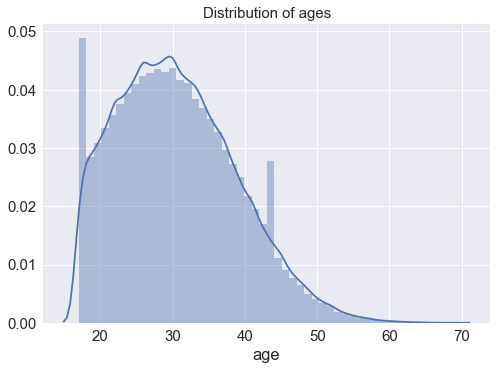

In [34]:
sns.set(font_scale=1.5) 
sns.distplot(raw_data['age'])
plt.title('Distribution of ages', size = 15)
# There might be only a few outliers

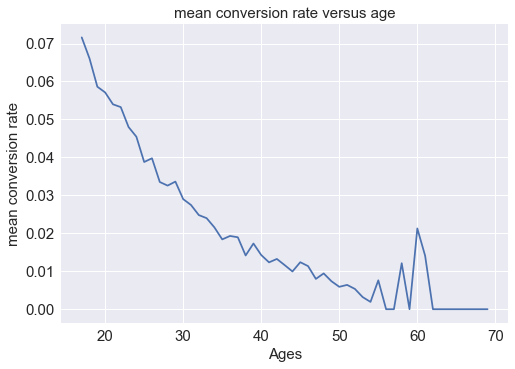

In [35]:
# plot the proportion of converted customers at different ages. 
raw_data = raw_data[raw_data['age'] < 70]
proportion_ages = raw_data.groupby('age')[['converted']].mean()
plt.plot(proportion_ages['converted'])
plt.title('mean conversion rate versus age', size = 15)
plt.xlabel('Ages', size = 15)
plt.ylabel('mean conversion rate', size = 15)
plt.tick_params(labelsize=15)
# It seems that the higher the age, the lower the conversion rate. 

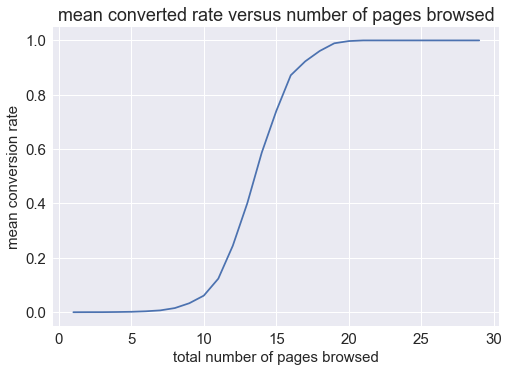

In [36]:
proportion_pages = raw_data.groupby('total_pages_visited')[['converted']].mean()
plt.plot(proportion_pages['converted'])
plt.title('mean converted rate versus number of pages browsed')
plt.xlabel('total number of pages browsed', size = 15)
plt.ylabel('mean conversion rate', size = 15)
plt.tick_params(labelsize=15)

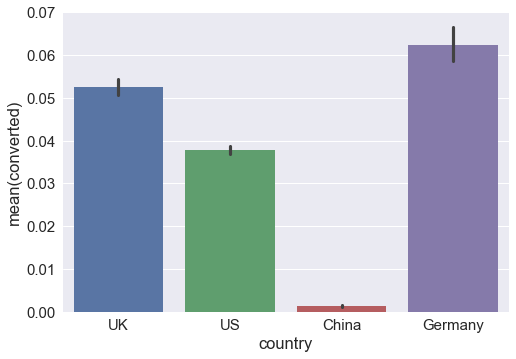

In [37]:
sns.barplot(x='country',y='converted',data=raw_data)
# Germany has the highest conversion rate and China's conversion rate is extremely low. 

# Use logistic regression model to predict conversion

In [42]:
# one hot encode the categorical variables
conversion_data = pd.get_dummies(raw_data, columns=['country', 'source'], drop_first=True)

In [41]:
conversion_data.head(2)

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1


In [58]:
X = conversion_data.drop('converted', axis = 1)
y = conversion_data['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)

In [57]:
print "The accuracy of the logistic regression classifier is {}.".format(accuracy_score(y_test, y_pred))
print "The auc-roc of the logistic regression classifier is {}.".format(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, y_pred))
# The recall for not_converted is 1, and the recall for converted is 0.68. Depending on how much cost we can bear to 
# lose a potential customer, we can adjust the threshold to increase the recall for "1" class.  

The accuracy of the logistic regression classifier is 0.98598965828.
The auc-roc of the logistic regression classifier is 0.985223321655.
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     61169
          1       0.86      0.68      0.76      2070

avg / total       0.99      0.99      0.99     63239



In [70]:
coeff_df = pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_[0]))))
coeff_df.columns = ['feature', 'coefficient']
coeff_df.sort_values('coefficient', ascending = False, inplace = True)

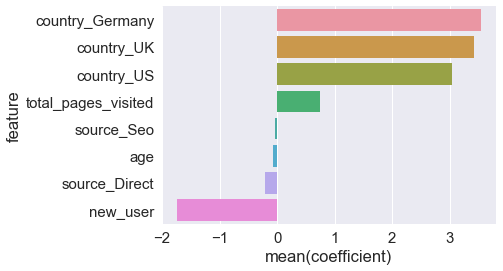

In [71]:
ax = sns.barplot(x = 'coefficient', y = 'feature', data = coeff_df)

Conclusion
1) The country of the user plays a large role in conversion. Germany, UK, US all got large positive coefficients, which agrees with the EDA result that China has a particular low conversion rate. 
2) Total number of pages also have a positive impact on the conversion. So the website should work on to increase user engagement or the time that user stayed on the website. 
3) A new user tends to convert less frequently than an old user, which suggests that the website should focus more on the old user, e.g., by sending them coupons to stimulate purchase. 
4) The source seems to not matter much. 
5) Surprisingly, age seems to be an important factor in the EDA, however, it's coeffient is rather small here. 